In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import stylia as st
from stylia import NamedColors
from stylia import ContinuousColorMap
from stylia import TWO_COLUMNS_WIDTH

import sys
sys.path.append("../src")
from plotting import draw_pie_marker, hit_enrichment, precision50


DATAPATH = "../data"
FIGUREPATH = "../figures"

In [2]:
import palettable
palettable.cartocolors.qualitative.Prism_9.hex_colors

['#5F4690',
 '#1D6996',
 '#38A6A5',
 '#0F8554',
 '#73AF48',
 '#EDAD08',
 '#E17C05',
 '#CC503E',
 '#94346E']

# Data Loading

In [3]:
assays = ['nf54','k1', 'mtb', 'cho', 'hepg2','clintH', 'clintM', 'clintR', 'caco', 'sol', 'herg', "cyp2c9", "cyp2c19", 'cyp3a4', 'cyp2d6']
f1 = ["nf54", "clintH", "cyp3a4", "herg"]
sf1 = ['k1', 'mtb', 'cho', 'hepg2','clintM', 'clintR', 'caco', 'sol',"cyp2c9", "cyp2c19",'cyp2d6']

In [4]:
assays_fold5 =  {
        "nf54":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","nf54_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_nf54_test_5.csv"))],
        "k1":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","k1_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_k1_test_5.csv"))],
        "pi4kb":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","pi4kb_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_pi4kb_test_5.csv"))],
        "mtb":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","mtb_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_mtb_test_5.csv"))],
        "cho":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","cho_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_cho_test_5.csv"))],
        "hepg2":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","hepg2_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_hepg2_test_5.csv"))],
        "clintH":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","clintH_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_clintH_test_5.csv"))],
        "clintM": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","clintM_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_clintM_test_5.csv"))],
        "clintR": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","clintR_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_clintR_test_5.csv"))],
        "caco":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","caco_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_caco_test_5.csv"))],
        "sol":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","sol_test_5.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "random_splits","output_sol_test_5.csv"))],
        "cyp3a4":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp3a4.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp3a4_subset.csv"))],
        "cyp2d6":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp2d6.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp2d6_subset.csv"))],
        "cyp2c9":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp2c9.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp2c9_subset.csv"))],
        "cyp2c19":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets","cyp2c19.csv")), 
                pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "full","output_cyp2c19_subset.csv"))],
        "herg":[pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets", "herg.csv")),
            pd.read_csv(os.path.join(DATAPATH, "predictions", "eos_models", "herg_eos2ta5.csv"))]
        }
#rename herg so it has same output column name
assays_fold5["herg"][1].rename(columns={"probability":"clf_ex1"}, inplace=True)

In [5]:
named_colors = NamedColors()
red = named_colors.get('red')
blue = named_colors.get('blue')
gray = named_colors.get('gray')

In [6]:
names= {
    "nf54" : "Pf NF54",
    "k1": "Pf K1",
    "mtb": "Mtb H37Rv",
    "cho": "CHO",
    "hepg2": "HepG2",
    "clintH": "CLint H",
    "clintM": "CLint M",
    "clintR" : "CLint R",
    "herg": "hERG",
    "sol": "Aq Sol",
    "sol65" : "Aq Sol",
    "caco" : "Caco-2",
    "cyp3a4": "P450 CYP3A4",
    "cyp2c9": "P450 CYP2C9",
    "cyp2c19": "P450 CYP2C19",
    "cyp2d6": "P450 CYP2D6",
}

In [7]:
# Select assays
def assay_selection(a):
    if a == "herg":
        assay = "herg"
        probacol = "probability"
        model_io = {
                "fold1": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_1.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models", "eos2ta5_{0}_train_1.csv".format(assay)))],
                "fold2": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_2.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_2.csv".format(assay)))],
                "fold3": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_3.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_3.csv".format(assay)))],
                "fold4": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_4.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_4.csv".format(assay)))],
                "fold5": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_5.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","eos_models","eos2ta5_{0}_train_5.csv".format(assay)))],
                }
    elif "cyp" in a:
        assay = a
        probacol = "clf_ex1"
        model_io = {
                "fold1": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_1.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_1.csv".format(assay)))],
                "fold2": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_2.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_2.csv".format(assay)))],
                "fold3": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_3.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_3.csv".format(assay)))],
                "fold4": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_4.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_4.csv".format(assay)))],
                "fold5": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_train_5.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_train_5.csv".format(assay)))],
                }
    else:
        assay = a
        probacol="clf_ex1"
        model_io = {
                "fold1": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_1.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_1.csv".format(assay)))],
                "fold2": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_2.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_2.csv".format(assay)))],
                "fold3": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_3.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_3.csv".format(assay)))],
                "fold4": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_4.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_4.csv".format(assay)))],
                "fold5": [pd.read_csv(os.path.join(DATAPATH, "dotmatics", "random_splits","{0}_test_5.csv".format(assay))), 
                        pd.read_csv(os.path.join(DATAPATH, "predictions","zairachem", "random_splits","output_{0}_test_5.csv".format(assay)))],
                }
    return probacol, model_io

# Figure 1
Max height of Natur figure: 247 mm = 9.72441 inches

Top pannel:
- Diagram of screening cascade at h3d: width 2COLS / height: 1.4906
Upper pannel:
- Left hand side: width: 2COLS/3*2 / height: 2.36
- Right hand side (with two subplots): 2COLS/3*1 / height: 2.36

Lower pannel:
- Left hand side (4 rows with 2 subplots each): 2COLS/4*3 / height: 1.9555*2
- Right hand side (4 rows with one subplot each): 2COLS/4*1 / height: 1.9555

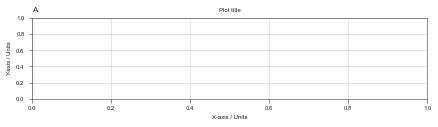

In [8]:
#Figure 1A Placeholder
fig, axs = st.create_figure(1,1, width=TWO_COLUMNS_WIDTH, height=1.4906)
ax = axs[0]
st.label(ax,abc="A")
plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "A.pdf")) #savefig to be sure we are using the same sizes

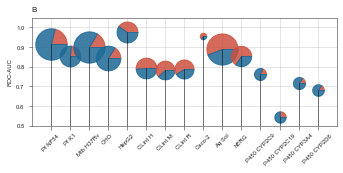

In [10]:
#Figure 1B

fig, axs = st.create_figure(1,1, width=(TWO_COLUMNS_WIDTH/3)*2, height=2.3622)
ax = axs[0]

all_aucs = []
all_aucs_std = []
counts = []
ratios = []
assay_names = []
for a in assays:
    probacol, model_io = assay_selection(a)
    aucs = []
    for k,v in model_io.items():
        yt = v[0]["bin"]
        proba1 = v[1][probacol]
        roc_auc = metrics.roc_auc_score(yt, proba1)
        aucs.append(roc_auc)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    all_aucs += [mean_auc]
    all_aucs_std += [std_auc]
    #get from the last fold representative measures
    counts += [len(yt)]
    act = len(v[0][v[0]["bin"]==1])
    inact = len(v[0][v[0]["bin"]==0])
    ratios += [[act/len(v[0]), inact/len(v[0])]]
    for k,v in names.items():
        if a == k:
            assay_names += [v]

x = [i for i in range(len(all_aucs))]
sizes = [c*3 for c in counts]

for i in range(len(assays)):
    draw_pie_marker(ax, 
      xs = [x[i]],
      ys = all_aucs[i],
      ratios = ratios[i],
      sizes = sizes[i],
      colors = [red, blue]
      )
   
    ax.plot([i,i], [0, all_aucs[i]], color="black", zorder=1)
    ax.set_xticks(x)
    ax.set_xticklabels(assay_names,rotation=45)
    ax.tick_params("y")
    ax.set_ylim(0.5, 1.05)
    ax.set_xlim(-1, len(assays))

st.label(
    ax,
    title="",
    xlabel="",
    ylabel="ROC-AUC",
    abc="B",
)
plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "B.pdf"))

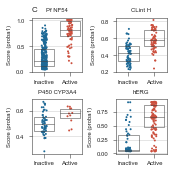

In [6]:
#Figure 1C
#swarmplots will use only one representative fold
#in the case of herg and cyps, we will use the whole dataset

fig, axs = st.create_figure(2,2, width=(TWO_COLUMNS_WIDTH/3)*1, height=2.3622)

for i,x in enumerate(f1):
    ax = axs[i]
    for k,v in assays_fold5.items():
        if k == x:
            v[1]["bin"] = v[0]["bin"] #add real outcome binarized
            sns.stripplot(
                        x="bin",
                        y="clf_ex1",
                        data=v[1],
                        ax=ax,
                        palette=[blue, red], 
                        s = 2,
                        zorder=1
                        )
            sns.boxplot(
                        x="bin",
                        y="clf_ex1",
                        data=v[1],
                        showcaps=False,boxprops={'facecolor':'None', "zorder":10},
                        showfliers=False,whiskerprops={'linewidth':0, "zorder":10},
                        ax=ax,
                        zorder=10
                        )
            ax.set_xticks([0, 1])
            ax.set_xticklabels(["Inactive", "Active"])
            if i == 0:
                abc = "C"
            else:
                abc = ""

            assay_name = names[f1[i]]
            st.label(
            ax,
            title="{}".format(assay_name),
            xlabel="",
            ylabel="Score (proba1)",
            abc=abc
            )
            plt.tight_layout()

    plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "C.pdf"))

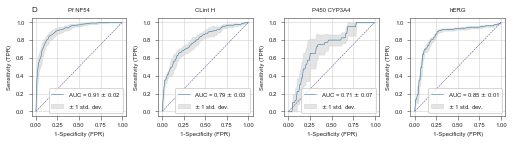

In [8]:
# Figure 1D: ROC Curve only
fig, axs = st.create_figure(1,4, width=TWO_COLUMNS_WIDTH, height=1.9555)

for i in range(4):
    assay = f1[i]
    probacol, model_io = assay_selection(assay)
    ax = axs[i]
    #interpolate roc curves from the random split folds
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for k,v in model_io.items():
        yt = v[0]["bin"]
        proba1 = v[1][probacol]
        fpr, tpr, _ = metrics.roc_curve(yt, proba1)
        roc_auc = metrics.roc_auc_score(yt, proba1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=blue,
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
    ax.plot([0, 1], [0, 1], ls="--")
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=gray,
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
    ax.legend(loc="lower right")
    if i == 0:
        abc = "D"
    else:
        abc = ""
    st.label(
            ax,
            title="{}".format(names[f1[i]]),
            xlabel="1-Specificity (FPR)",
            ylabel="Sensitivity (TPR)",
            abc=abc
            )

    plt.tight_layout()
    #plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "D.pdf"))

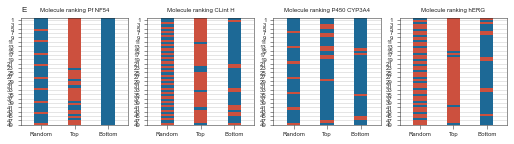

In [8]:
#Figure 1E
fig, axs = st.create_figure(1,4, width=TWO_COLUMNS_WIDTH, height=1.9555)

for i in range(4):
    ax = axs[i]
    v = assays_fold5[f1[i]]
    v[1]["bin"] = v[0]["bin"] #add real outcome binarized
    if len(v[1])>= 50:
        pos_prop = len(v[1][v[1]["bin"]==1])/len(v[1])
        total_pos = int(50*pos_prop)
        idxs = [int(x) for x in np.linspace(0,49,total_pos)]
        x = np.zeros(50)
        x[idxs] = 1
        random = x.tolist()
        c_r = [red if b==1 else blue for b in random]
        x_r = [-2.5 for i in range(len(random))]
        y_r = [i for i in range(1, len(random)+1)]

        ranked_top = v[1].sort_values("clf_ex1")[-50:]
        c_rank_top = [red if b ==1 else blue for b in ranked_top["bin"]]
        x_rank_top = [0 for i in range(len(ranked_top))]
        y_rank_top = [i for i in range(1, len(ranked_top)+1)]

        ranked_bot = v[1].sort_values("clf_ex1", ascending=False)[-50:]
        c_rank_bot = [red if b ==1 else blue for b in ranked_bot["bin"]]
        x_rank_bot = [2.5 for i in range(len(ranked_bot))]
        y_rank_bot = [i for i in range(1, len(ranked_bot)+1)]

        precision50(ax, x_r, y_r, c_r, x_rank_top, y_rank_top, c_rank_top, x_rank_bot, y_rank_bot, c_rank_bot)
        if i == 0:
            abc = "E"
        else:
            abc = ""
        st.label(
                ax,
                title="Molecule ranking {}".format(names[f1[i]]),
                xlabel="",
                ylabel="",
                abc=abc
                )

        plt.tight_layout()
        plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "E.pdf"))

# Extra Figure 1

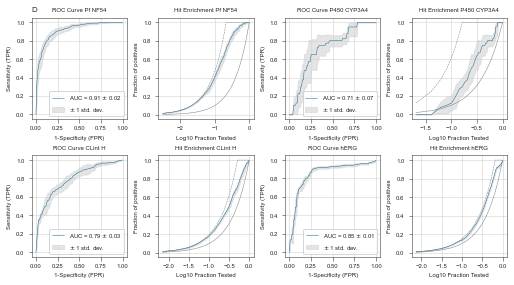

In [11]:
# Figure 1D_: ROC Curve and Hit Enrichement
fig, axs = st.create_figure(2,4, width=TWO_COLUMNS_WIDTH, height=3.9146)
idx = [0,1,0,1,]

for i in range(4):
    assay = f1[i]
    probacol, model_io = assay_selection(assay)
    
    if i <= 1:
        ax = axs[i,0]
    else:
        i_ = idx[i]
        ax = axs[i_,2]
    #interpolate roc curves from the random split folds
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for k,v in model_io.items():
        yt = v[0]["bin"]
        proba1 = v[1][probacol]
        fpr, tpr, _ = metrics.roc_curve(yt, proba1)
        roc_auc = metrics.roc_auc_score(yt, proba1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=blue,
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=gray,
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
    ax.legend(loc="lower right")
    if i == 0:
        abc = "D"
    else:
        abc = ""
    st.label(
            ax,
            title="ROC Curve {}".format(names[f1[i]]),
            xlabel="1-Specificity (FPR)",
            ylabel="Sensitivity (TPR)",
            abc=abc
            )
    if i <= 1:
        ax = axs[i,1]
    else:
        i_ = idx[i]
        ax = axs[i_,3]
    hit_enrs = []
    for k,v in model_io.items():
        v[1]["bin"]=v[0]["bin"]
        frac_tested, hit_enr, ideal, random = hit_enrichment(v[1], probacol)
        hit_enrs += [hit_enr]

    mean_hit_enr = np.mean(hit_enrs, axis=0)
    ax.plot(np.log10(frac_tested), mean_hit_enr, color =blue)
    ax.plot(np.log10(frac_tested), ideal, color = "grey", linestyle = "dashed", lw=0.5)
    ax.plot(np.log10(frac_tested), random, color = "grey", lw=0.5)

    std_hit_enr = np.std(hit_enrs, axis=0)
    hit_enr_upper = np.minimum(mean_hit_enr + std_hit_enr, 1)
    hit_enr_lower = np.maximum(mean_hit_enr - std_hit_enr, 0)
    ax.fill_between(
        np.log10(frac_tested),
        hit_enr_lower,
        hit_enr_upper,
        color=gray,
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )

    st.label(
        ax,
        title = "Hit Enrichment {}".format(names[f1[i]]),
        xlabel = "Log10 Fraction Tested",
        ylabel="Fraction of positives"
        )

    plt.tight_layout()
    #plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "D_.pdf"))

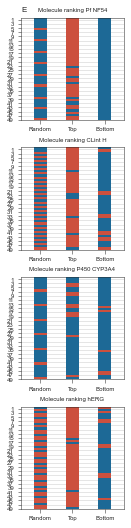

In [9]:
#Figure 1E_
fig, axs = st.create_figure(4,1, width=(TWO_COLUMNS_WIDTH/4)*1, height=7.29)
for i in range(4):
    ax = axs[i]
    v = assays_fold5[f1[i]]
    v[1]["bin"] = v[0]["bin"] #add real outcome binarized
    if len(v[1])>= 50:
        pos_prop = len(v[1][v[1]["bin"]==1])/len(v[1])
        total_pos = int(50*pos_prop)
        idxs = [int(x) for x in np.linspace(0,49,total_pos)]
        x = np.zeros(50)
        x[idxs] = 1
        random = x.tolist()
        c_r = [red if b==1 else blue for b in random]
        x_r = [-2.5 for i in range(len(random))]
        y_r = [i for i in range(1, len(random)+1)]

        ranked_top = v[1].sort_values("clf_ex1")[-50:]
        c_rank_top = [red if b ==1 else blue for b in ranked_top["bin"]]
        x_rank_top = [0 for i in range(len(ranked_top))]
        y_rank_top = [i for i in range(1, len(ranked_top)+1)]

        ranked_bot = v[1].sort_values("clf_ex1", ascending=False)[-50:]
        c_rank_bot = [red if b ==1 else blue for b in ranked_bot["bin"]]
        x_rank_bot = [2.5 for i in range(len(ranked_bot))]
        y_rank_bot = [i for i in range(1, len(ranked_bot)+1)]

        precision50(ax, x_r, y_r, c_r, x_rank_top, y_rank_top, c_rank_top, x_rank_bot, y_rank_bot, c_rank_bot)
        if i == 0:
            abc = "E"
        else:
            abc = ""
        st.label(
                ax,
                title="Molecule ranking {}".format(names[f1[i]]),
                xlabel="",
                ylabel="",
                abc=abc
                )
        plt.tight_layout()
        #plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "E_.pdf"))

## Supplementary Figure 1, 2, 3
* S1: Scores for the models not depicted in main figure (11 models) = 3 rows x 4 columns
* S2: ROC Curves not depicted in main figure (11 models) = 6 rows x 4 columns 
* S3: Molecule ranking at 50 mols for the models not depicted in main figure (10 models, caco does not have enough) = 2 rows x 5 cols
* S4: hit enrichments of all assys = 4 rows x 4 columns

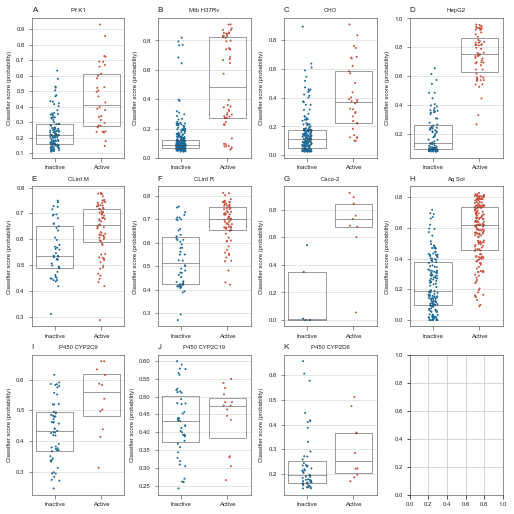

In [7]:
# Supplementary Figure 1
fig, axs = st.create_figure(3,4, width=(TWO_COLUMNS_WIDTH), height=TWO_COLUMNS_WIDTH)
abc = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
for i,x in enumerate(sf1):
    ax = axs[i]
    for k,v in assays_fold5.items():
        if k == x:
            v[1]["bin"] = v[0]["bin"] #add real outcome binarized
            sns.stripplot(
                        x="bin",
                        y="clf_ex1",
                        data=v[1],
                        ax=ax,
                        palette=[blue,red], 
                        s = 2,
                        zorder=1
                        )
            sns.boxplot(
                        x="bin",
                        y="clf_ex1",
                        data=v[1],
                        showcaps=False,boxprops={'facecolor':'None', "zorder":10},
                        showfliers=False,whiskerprops={'linewidth':0, "zorder":10},
                        ax=ax,
                        zorder=10
                        )
            ax.set_xticks([0, 1])
            ax.set_xticklabels(["Inactive", "Active"])
            st.label(
            ax,
            title="{}".format(names[sf1[i]]),
            xlabel="",
            ylabel="Classifier score (probability)",
            abc=abc[i]
            )
            plt.tight_layout()

    plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "SF1.pdf"))


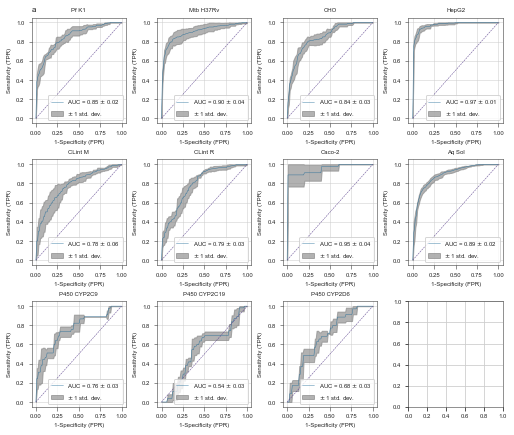

In [14]:
# Supplementary Figure 2: ROC Curves
fig, axs = st.create_figure(3,4, width=(TWO_COLUMNS_WIDTH), height=6)

for i in range(11):
    assay = sf1[i]
    probacol, model_io=assay_selection(assay)
    ax = axs[i]
    #interpolate roc curves from the random split folds
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for k,v in model_io.items():
        yt = v[0]["bin"]
        proba1 = v[1][probacol]
        fpr, tpr, _ = metrics.roc_curve(yt, proba1)
        roc_auc = metrics.roc_auc_score(yt, proba1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=blue,
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
        alpha=0.8
    )
    ax.plot([0, 1], [0, 1], ls="--")
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
    ax.legend(loc="lower right")
    if i == 0:
        abc = "a"
    else:
        abc = ""
    st.label(
            ax,
            title="{}".format(names[sf1[i]]),
            xlabel="1-Specificity (FPR)",
            ylabel="Sensitivity (TPR)",
            abc=abc
            )

    plt.tight_layout()
    plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "SF2.pdf"))

In [ ]:
# Supplementary Figure 3: Precision 50
fig, axs = st.create_figure(2,5, width=(TWO_COLUMNS_WIDTH))

for i,sa in enumerate(sf1):
    if i > 6:
        ax = axs[i-1]
    else:
        ax = axs[i]
    v = assays_fold5[sa]
    v[1]["bin"] = v[0]["bin"] #add real outcome binarized
    if len(v[1])>= 50:
        pos_prop = len(v[1][v[1]["bin"]==1])/len(v[1])
        total_pos = int(50*pos_prop)
        idxs = [int(x) for x in np.linspace(0,49,total_pos)]
        x = np.zeros(50)
        x[idxs] = 1
        random = x.tolist()
        c_r = [red if b==1 else blue for b in random]
        x_r = [-2.5 for i in range(len(random))]
        y_r = [i for i in range(1, len(random)+1)]

        ranked_top = v[1].sort_values("clf_ex1")[-50:]
        c_rank_top = [red if b ==1 else blue for b in ranked_top["bin"]]
        x_rank_top = [0 for i in range(len(ranked_top))]
        y_rank_top = [i for i in range(1, len(ranked_top)+1)]

        ranked_bot = v[1].sort_values("clf_ex1", ascending=False)[-50:]
        c_rank_bot = [red if b ==1 else "#1D6996" for b in ranked_bot["bin"]]
        x_rank_bot = [2.5 for i in range(len(ranked_bot))]
        y_rank_bot = [i for i in range(1, len(ranked_bot)+1)]

        precision50(ax, x_r, y_r, c_r, x_rank_top, y_rank_top, c_rank_top, x_rank_bot, y_rank_bot, c_rank_bot)
        st.label(
                ax,
                title="Molecule ranking {}".format(names[sf1[i]]),
                xlabel="",
                ylabel="",
                abc=abc[i]
                )
        plt.tight_layout()
        plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "SF3.pdf"))

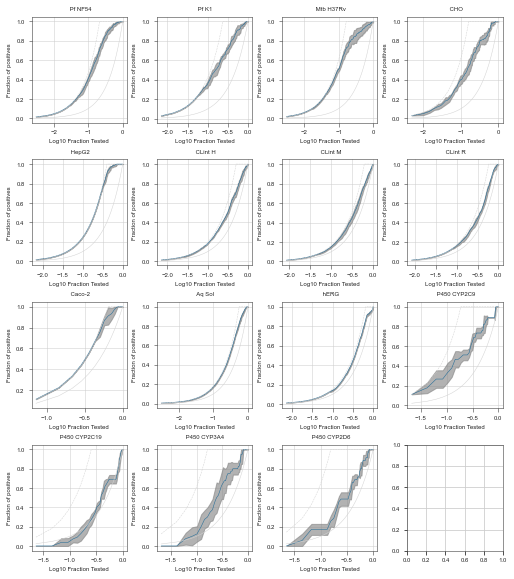

In [10]:
# Supplementary Figure 4: Hit Enrichments

fig, axs = st.create_figure(4,4, width=(TWO_COLUMNS_WIDTH), height = 8)

for i in range(15):
    assay = assays[i]
    probacol, model_io=assay_selection(assay)
    ax = axs[i]
    hit_enrs = []
    for k,v in model_io.items():
        v[1]["bin"]=v[0]["bin"]
        frac_tested, hit_enr, ideal, random = hit_enrichment(v[1], probacol)
        hit_enrs += [hit_enr]

    mean_hit_enr = np.mean(hit_enrs, axis=0)
    ax.plot(np.log10(frac_tested), mean_hit_enr, color =blue)
    ax.plot(np.log10(frac_tested), ideal, color = gray, linestyle = "dashed", lw=0.5)
    ax.plot(np.log10(frac_tested), random, color = gray, lw=0.5)

    std_hit_enr = np.std(hit_enrs, axis=0)
    hit_enr_upper = np.minimum(mean_hit_enr + std_hit_enr, 1)
    hit_enr_lower = np.maximum(mean_hit_enr - std_hit_enr, 0)
    ax.fill_between(
        np.log10(frac_tested),
        hit_enr_lower,
        hit_enr_upper,
        color="grey",
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )

    st.label(
        ax,
        title = " {}".format(names[assays[i]]),
        xlabel = "Log10 Fraction Tested",
        ylabel="Fraction of positives"
        )
    plt.tight_layout()
    plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "SF4.pdf"))

In [ ]:
# Supplementary Figure 2 (old)

fig, axs = st.create_figure(6,4, width=(TWO_COLUMNS_WIDTH), height=TWO_COLUMNS_WIDTH*1.5)
idx = [0,1,2,3,4,5,0,1,2,3,4,5]
abc = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]

for i in range(11):
    assay = sf1[i]
    probacol, model_io=assay_selection(assay)
    if i <= 5:
        ax = axs[i,0]
    else:
        i_ = idx[i]
        ax = axs[i_,2]
    #interpolate roc curves from the random split folds
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for k,v in model_io.items():
        yt = v[0]["bin"]
        proba1 = v[1][probacol]
        fpr, tpr, _ = metrics.roc_curve(yt, proba1)
        roc_auc = metrics.roc_auc_score(yt, proba1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=blue,
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8
    )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
    ax.legend(loc="lower right")
    st.label(
            ax,
            title="ROC Curve {}".format(names[sf1[i]]),
            xlabel="1-Specificity (FPR)",
            ylabel="Sensitivity (TPR)",
            abc=abc[i]
            )

    hit_enrs = []
    if i <= 5:
        ax = axs[i,1]
    else:
        i_ = idx[i]
        ax = axs[i_,3]
    for k,v in model_io.items():
        v[1]["bin"]=v[0]["bin"]
        frac_tested, hit_enr, ideal, random = hit_enrichment(v[1], probacol)
        hit_enrs += [hit_enr]

    mean_hit_enr = np.mean(hit_enrs, axis=0)
    ax.plot(np.log10(frac_tested), mean_hit_enr, color =blue)
    ax.plot(np.log10(frac_tested), ideal, color = gray, linestyle = "dashed", lw=0.5)
    ax.plot(np.log10(frac_tested), random, color = gray, lw=0.5)

    std_hit_enr = np.std(hit_enrs, axis=0)
    hit_enr_upper = np.minimum(mean_hit_enr + std_hit_enr, 1)
    hit_enr_lower = np.maximum(mean_hit_enr - std_hit_enr, 0)
    ax.fill_between(
        np.log10(frac_tested),
        hit_enr_lower,
        hit_enr_upper,
        color="grey",
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
        )

    st.label(
        ax,
        title = "Hit Enrichment {}".format(names[sf1[i]]),
        xlabel = "Log10 Fraction Tested",
        ylabel="Fraction of positives"
        )

    plt.tight_layout()
    plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure2", "SF2_.pdf"))

# Figure 4
* Panel A: ROC Curves of nf54, k1, cho, solubility: 1 vertical panel with 4 rows, height =  1.9555*4
* Panel B: Array of vector colors, height = 1.9555*4
* Panel C: selected molecules with structure: 1.9555 each
* Panel D: predicted vs real values

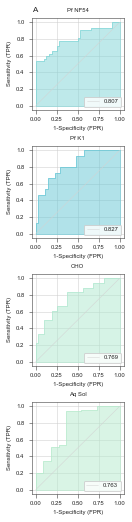

In [9]:
# Figure 4A
df = pd.read_csv(os.path.join(DATAPATH, "predictions", "zairachem", "retrospective2", "jmedchem2020_allpreds.csv"))

fig, axs = st.create_figure(4,1, width=(TWO_COLUMNS_WIDTH)/4, height = (1.8*4))

def get_ys(df):
    cols = list(df.columns)
    if "proba1" in cols:
        return list(df["proba1"])
    for c in cols:
        if c.startswith("clf_"):
            return list(df[c])
        if c.startswith("bin"):
            return list(df[c])
        if c.startswith("proba"):
            return list(df[c])
    return None


def roc_plot(ax, y_true, y_pred):
    cmap = ContinuousColorMap(cmap="spectral")
    cmap.fit([0.5, 1])
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auroc = auc(fpr, tpr)
    color = cmap.transform([auroc])[0]
    ax.plot(fpr, tpr, color=color)
    ax.fill_between(fpr, tpr, color=color, alpha=0.5)
    ax.plot([0,1], [0,1], lw=0.5, color=NamedColors().gray, label=str(np.round(auroc, 3)))
    ax.legend(loc = "lower right")


assays=['nf54','k1', 'cho',"sol65"]
for i,a in enumerate(assays):
    ax = axs[i]
    if a == "sol65":
        real_subset = df[~df["sol_real_bin"].isna()]
    else: 
        real_subset = df[~df["{}_real_bin".format(a)].isna()]

    if a == "sol65":
        yt = real_subset["sol_real_bin"]
    else:
        yt = real_subset["{}_real_bin".format(a)]
    y_pred = real_subset["proba1_{}".format(a)]
    roc_plot(ax, yt, y_pred)
    if i == 0:
        abc="A"
    else:
        abc =""
    st.label(
        ax,
        title=("{}".format(names[a])),
        xlabel=("1-Specificity (FPR)"),
        ylabel=("Sensitivity (TPR)"),
        abc=abc,
    )
    plt.tight_layout()
    #plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure4", "A.pdf"))

/home/gturon/anaconda3/envs/chemistry/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


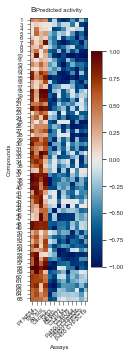

In [12]:
#Figure 4B
assays = ['nf54','k1', 'sol65','caco', 'cho','herg', 'clintH', 'clintM', 'clintR', 'cyp3a4', 'cyp2d6', 
       'cyp2c9','cyp2c19']

assay_names = []
for a in assays:
    assay_names += [names[a]]

col_order=[]
for a in assays:
    col = "proba1_{}_trn".format(a)
    col_order += [col]

neg = ['clintH', 'clintM', 'clintR','cho', 'herg', 'cyp3a4', 'cyp2d6','cyp2c9', 'cyp2c19']
negative = ["proba1_{}_trn".format(n) for n in neg]

df2 = df[col_order]
arr = df2.to_numpy()

for n in negative:
    for i,c in enumerate(col_order):
        if "{}".format(n) == c:
            arr[:,i] = -np.abs(arr[:,i])


fig, axs = st.create_figure(1,1, width=(TWO_COLUMNS_WIDTH)/4, height = 1.8*4)
ax = axs[0]

from stylia.colors.colors import NamedColorMaps

cmap = NamedColorMaps().get("coolwarm")

im = ax.imshow(arr, cmap=cmap)
ax.set_yticks(np.arange(len(df)))
ax.set_yticklabels(df["cpds"])
ax.set_xticks(np.arange(len(assays)))
ax.set_xticklabels(assay_names)
plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

st.label(
    ax,
    title=("Predicted activity"),
    xlabel=("Assays"),
    ylabel=("Compounds"),
    abc="B"
)
plt.tight_layout()

ax.grid()

plt.savefig(os.path.join(FIGUREPATH, "paper_figures", "figure4", "B_colorbar.pdf"))

In [23]:
# Figure 4 UMAP
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

all =  pd.read_csv(os.path.join(DATAPATH, "dotmatics", "full_datasets", "allsmiles.csv"))
exp = pd.read_csv(os.path.join(DATAPATH, "dotmatics", "retrospective2", "jmedchem2020_binreal.csv"))
SMILES = "CAN_SMILES"

In [24]:
allsmi = all[SMILES]
expsmi = exp[SMILES]

allmol = [Chem.MolFromSmiles(s) for s in allsmi]
expmol = [Chem.MolFromSmiles(s) for s in expsmi]
allmorgan = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in allmol]
expmorgan = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in expmol]

In [31]:
import umap
umap_trn = umap.UMAP()
allumap = umap_trn.fit_transform(allmorgan)
expumap = umap_trn.transform(expmorgan)

allumap_tp = np.transpose(allumap)
expumap_tn = np.transpose(expumap)
plt.scatter(allumap_tp[0], allumap_tp[1])
plt.scatter(expumap_tn[0], expumap_tn[1])